# Grunsätzliche Ideen für später

- Für aktuelle Messwerte Messstaion abfragen.
    - https://opendata.swiss/de/dataset/automatische-wetterstationen-aktuelle-messwerte
- Für Prognose ein kurzfristiges Modell wählen.
    - Alle Kostenpflichtig, wird nicht weiter beachtet

In [21]:
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy


# Magic Numbers

Ich habe bei Drainage per hour einfach mal was angenommen, das gilt es noch richtig zu bestimmen.

In [22]:
RESAMPLE_MINUTES = 30

TOTAL_COLLECTIONG_AREA = 808500 # m^2
ABSORPTION_COEFFICIENT = 0.25
BASIN_COLLECTION_AREA = TOTAL_COLLECTIONG_AREA * (1 - ABSORPTION_COEFFICIENT)
RFB83_COLLECTION_AREA = BASIN_COLLECTION_AREA * 0.18
RFB83_DELAY_MINUTES = 30



In [23]:
## Drainage 

mm_per_min = 0.091666667
m_per_min = mm_per_min / 1000
laenge_becken = 110
breite_becken = 20
# flaeche_becken = laenge_becken * breite_becken
flaeche_becken = 2200 # m^2
tiefe_becken_gravel = 0.95
gravel_factor = 0.2
tiefe_becken_free = 0.2

volume_water_gravel = flaeche_becken * tiefe_becken_gravel * gravel_factor # m^3
volume_water_free = flaeche_becken * tiefe_becken_free
volume_water_total = volume_water_gravel + volume_water_free

L_WATER_TOTAL = volume_water_total * 1000 # L

print(f"Liter water total: {L_WATER_TOTAL} L")

print(f"Volume water gravel: {volume_water_gravel} m^3")
print(f"Volume water free: {volume_water_free} m^3")
print(f"Volume water total: {volume_water_total} m^3")

m3_per_min = m_per_min * flaeche_becken
m3_per_h = m3_per_min * 60

RFB83_DRAINAGE_PER_HOUR = m3_per_h * 1000 # L/h
RFB83_DRAINAGE_PER_TIME_UNIT = RFB83_DRAINAGE_PER_HOUR / (60 / RESAMPLE_MINUTES) # L

MAX_DRAINAGE_LEVEL = 0.9
MAX_DRAINAGE_VOLUME_L = L_WATER_TOTAL * MAX_DRAINAGE_LEVEL # L

Liter water total: 858000.0 L
Volume water gravel: 418.0 m^3
Volume water free: 440.0 m^3
Volume water total: 858.0 m^3


In [24]:
def read_cosmo_data(file_path: Path | str) -> pd.DataFrame:
    df = pd.read_csv(file_path, skiprows=24, sep=";").iloc[:, :-1]

    # KLO is the station name (Kloten (Zuerich))
    df = df[df["stn"] == "KLO"]
    df = df.drop(columns=["stn"])

    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")

    df["leadtime"] = df["leadtime"].apply(
        lambda x: int(x.split(":")[0]) + int(x.split(":")[1]) / 60
    )

    # df = df[["leadtime", "TOT_PREC", "T_2M", "FF_10M", "DD_10M", "RELHUM_2M", "DURSUN"]]

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.replace(-999, np.nan)

    # upsample to 1h
    df = df.resample(pd.Timedelta(minutes=RESAMPLE_MINUTES)).mean().interpolate()

    temp_labels = ["T_2M"] + [f"T_2M.{i}" for i in range(1, 21)]
    df_ret = pd.DataFrame(index=df.index)
    df_ret["T_mean"] = df[temp_labels].mean(axis=1)
    df_ret["T_std"] = df[temp_labels].std(axis=1)
    df_ret["T_min"] = df[temp_labels].min(axis=1)
    df_ret["T_max"] = df[temp_labels].max(axis=1)

    prec_labels = ["TOT_PREC"] + [f"TOT_PREC.{i}" for i in range(1, 21)]
    df_ret["prec_mean"] = df[prec_labels].mean(axis=1) / 6
    df_ret["prec_std"] = df[prec_labels].std(axis=1) / 6
    df_ret["prec_min"] = df[prec_labels].min(axis=1) / 6
    df_ret["prec_max"] = df[prec_labels].max(axis=1) / 6

    humidity_labels = ["RELHUM_2M"] + [f"RELHUM_2M.{i}" for i in range(1, 21)]
    df_ret["humidity_mean"] = df[humidity_labels].mean(axis=1)
    df_ret["humidity_std"] = df[humidity_labels].std(axis=1)
    df_ret["humidity_min"] = df[humidity_labels].min(axis=1)
    df_ret["humidity_max"] = df[humidity_labels].max(axis=1)

    sun_labels = ["DURSUN"] + [f"DURSUN.{i}" for i in range(1, 21)]
    df_ret["sun_mean"] = df[sun_labels].mean(axis=1) / 3600 / 6
    df_ret["sun_std"] = df[sun_labels].std(axis=1) / 3600 / 6
    df_ret["sun_min"] = df[sun_labels].min(axis=1) / 3600 / 6
    df_ret["sun_max"] = df[sun_labels].max(axis=1) / 3600 / 6

    wind_vel_labels = ["FF_10M"] + [f"FF_10M.{i}" for i in range(1, 21)]
    df_ret["wind_vel_mean"] = df[wind_vel_labels].mean(axis=1)
    df_ret["wind_vel_std"] = df[wind_vel_labels].std(axis=1)
    df["wind_vel_mean"] = df_ret["wind_vel_mean"]
    df_ret["wind_vel_min"] = df[wind_vel_labels].min(axis=1)
    df_ret["wind_vel_max"] = df[wind_vel_labels].max(axis=1)

    wind_dir_labels = ["DD_10M"] + [f"DD_10M.{i}" for i in range(1, 21)]
    df_ret["wind_dir_mean"] = df.apply(
        lambda x: scipy.stats.circmean(x[wind_dir_labels], high=360, low=0), axis=1
    )
    df_ret["wind_dir_std"] = df.apply(
        lambda x: scipy.stats.circstd(x[wind_dir_labels], high=360, low=0), axis=1
    )

    return df_ret

In [25]:
download_url = "https://data.geo.admin.ch/ch.meteoschweiz.prognosen/punktprognosen/COSMO-E-all-stations.csv"

df = read_cosmo_data(download_url)

# Plots

In [26]:
def ax_settings(ax, title, ylabel):
    ax.tick_params(axis="x", rotation=45)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

    ax.tick_params(axis="x", which="minor", rotation=45)
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid()
    ax.grid(which="minor", linestyle="--")

    ax.axvline(pd.Timestamp.now(), color="red", linestyle="--", label="now")

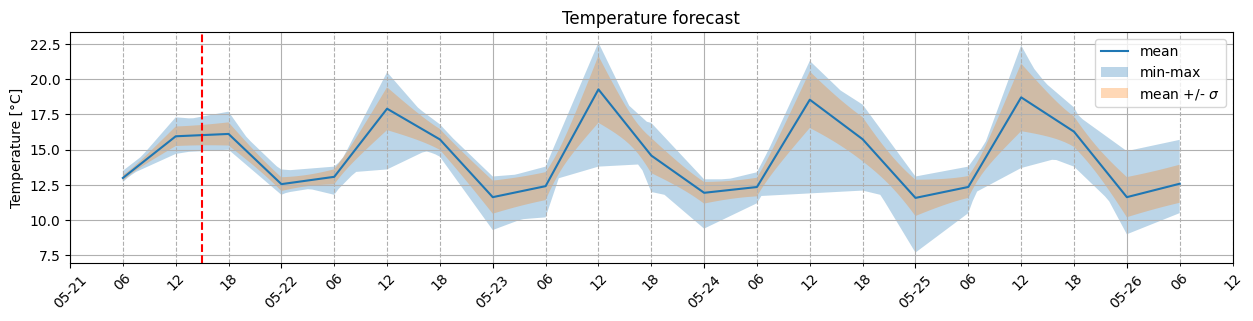

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(df.index, df["T_mean"], label="mean")
ax.fill_between(df.index, df["T_min"], df["T_max"], alpha=0.3, label="min-max")
ax.fill_between(
    df.index,
    df["T_mean"] - df["T_std"],
    df["T_mean"] + df["T_std"],
    alpha=0.3,
    label=r"mean +/- $\sigma$",
)

ax_settings(ax, "Temperature forecast", "Temperature [°C]")

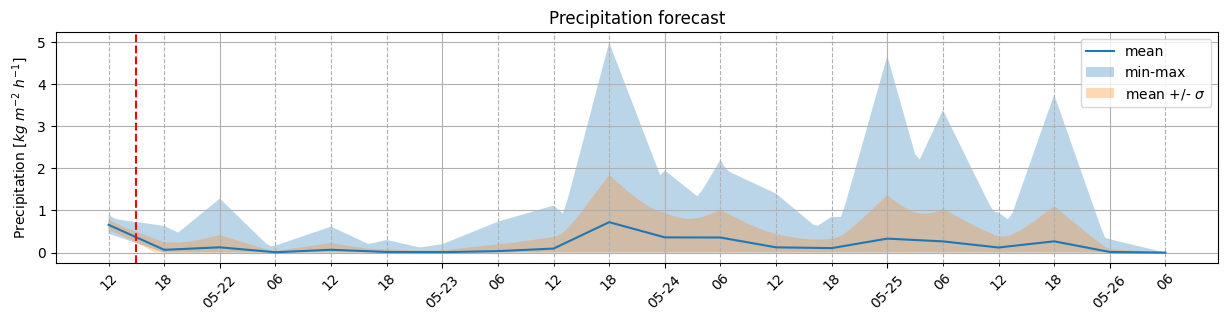

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(df.index, df["prec_mean"], label="mean")
ax.fill_between(df.index, df["prec_min"], df["prec_max"], alpha=0.3, label="min-max")
ax.fill_between(
    df.index,
    (df["prec_mean"] - df["prec_std"]).clip(lower=0),
    df["prec_mean"] + df["prec_std"],
    alpha=0.3,
    label=r"mean +/- $\sigma$",
)

ax_settings(ax, "Precipitation forecast", r"Precipitation [$kg\ m^{-2}\ h^{-1}$]")

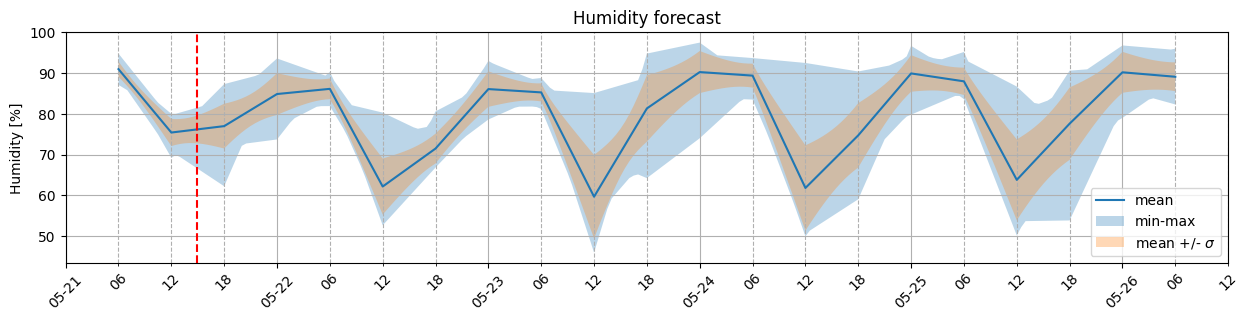

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(df.index, df["humidity_mean"], label="mean")
ax.fill_between(df.index, df["humidity_min"], df["humidity_max"], alpha=0.3, label="min-max")
ax.fill_between(
    df.index,
    df["humidity_mean"] - df["humidity_std"],
    df["humidity_mean"] + df["humidity_std"],
    alpha=0.3,
    label=r"mean +/- $\sigma$",
)

ax_settings(ax, "Humidity forecast", "Humidity [%]")

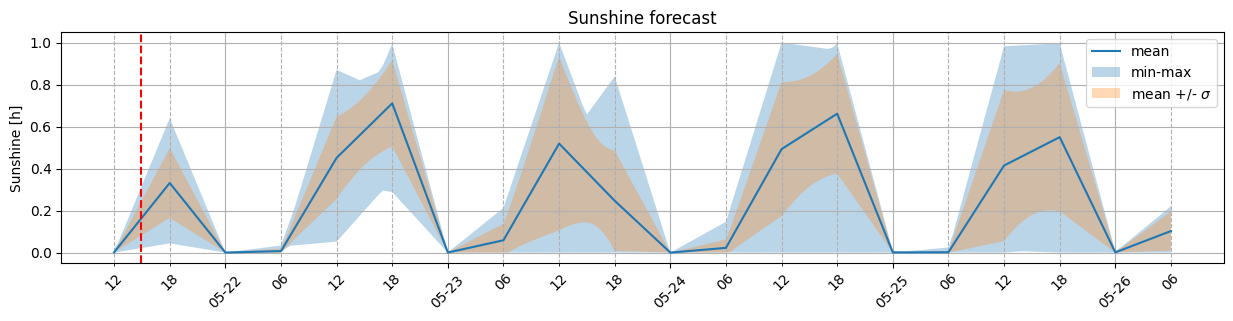

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(df.index, df["sun_mean"], label="mean")
ax.fill_between(df.index, df["sun_min"], df["sun_max"], alpha=0.3, label="min-max")
ax.fill_between(
    df.index,
    (df["sun_mean"] - df["sun_std"]).clip(lower=0),
    df["sun_mean"] + df["sun_std"],
    alpha=0.3,
    label=r"mean +/- $\sigma$",
)

ax_settings(ax, "Sunshine forecast", r"Sunshine [h]")

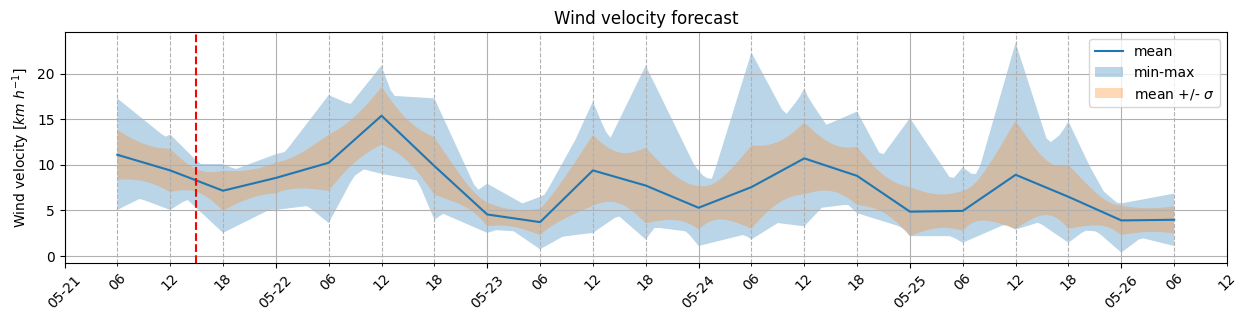

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(df.index, df["wind_vel_mean"] * 3.6, label="mean")
ax.fill_between(
    df.index, df["wind_vel_min"] * 3.6, df["wind_vel_max"] * 3.6, alpha=0.3, label="min-max"
)
ax.fill_between(
    df.index,
    (df["wind_vel_mean"] - df["wind_vel_std"]) * 3.6,
    (df["wind_vel_mean"] + df["wind_vel_std"]) * 3.6,
    alpha=0.3,
    label=r"mean +/- $\sigma$",
)

ax_settings(ax, "Wind velocity forecast", r"Wind velocity [$km\ h^{-1}$]")

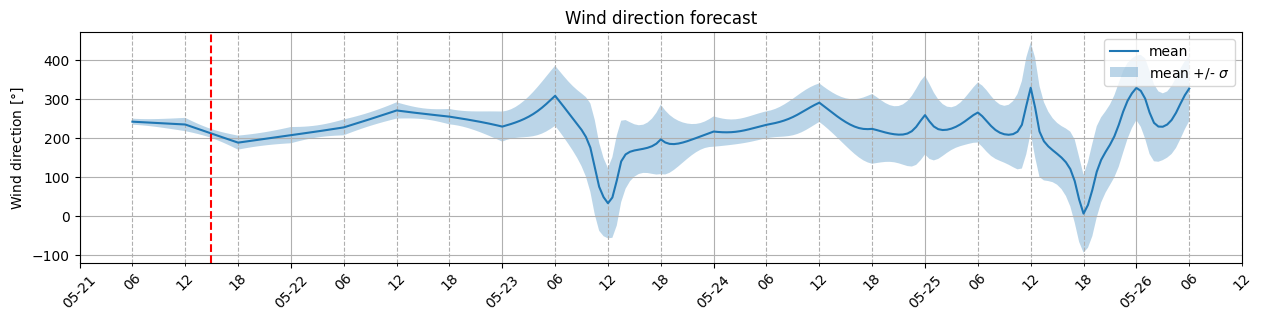

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(df.index, df["wind_dir_mean"], label="mean")
ax.fill_between(
    df.index,
    df["wind_dir_mean"] - df["wind_dir_std"],
    df["wind_dir_mean"] + df["wind_dir_std"],
    alpha=0.3,
    label=r"mean +/- $\sigma$",
)

ax_settings(ax, "Wind direction forecast", r"Wind direction [$°$]")

<>:74: SyntaxWarning: invalid escape sequence '\s'
<>:74: SyntaxWarning: invalid escape sequence '\s'
/var/folders/by/rv4bw4814w776660j1ywck6c0000gn/T/ipykernel_9338/1852732361.py:74: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(df_tmp["prec_drained_with_gates"], label="cum. prec. mean + $\sigma$ drained with gates")
/var/folders/by/rv4bw4814w776660j1ywck6c0000gn/T/ipykernel_9338/1852732361.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42365.621561768516' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_tmp.loc[df_tmp.index[i], "prec_drained"] = (
/var/folders/by/rv4bw4814w776660j1ywck6c0000gn/T/ipykernel_9338/1852732361.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42365.621561768516' has dtype incompatible with int64, please explicitly cast to a compatible

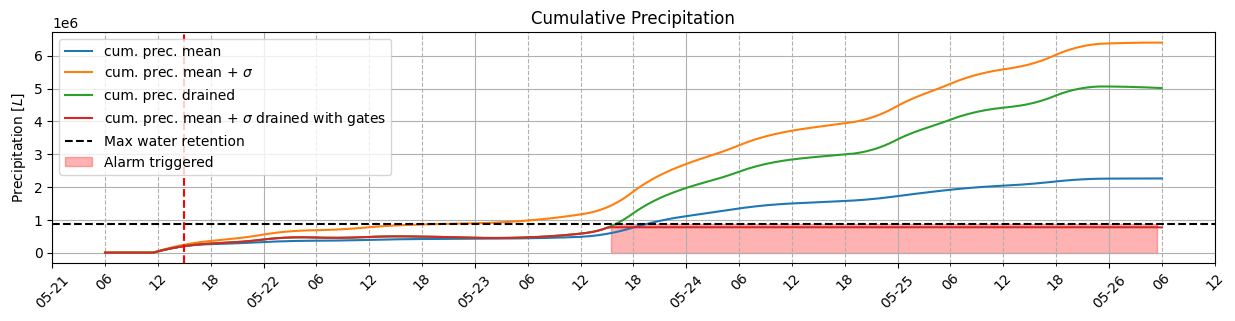

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

df_tmp = pd.DataFrame(index=df.index)

df_tmp["prec_mean_cumsum"] = (
    df["prec_mean"].cumsum() * (RESAMPLE_MINUTES / 60) * RFB83_COLLECTION_AREA
)
df_tmp["prec_std_cumsum"] = (
    df[["prec_mean", "prec_std"]].sum(axis=1).cumsum()
    * (RESAMPLE_MINUTES / 60)
    * RFB83_COLLECTION_AREA
)

df_tmp["prec_absolute"] = (
    df[["prec_mean", "prec_std"]].sum(axis=1) * (RESAMPLE_MINUTES / 60) * RFB83_COLLECTION_AREA
)
df_tmp["prec_drained"] = 0

for i in range(1, len(df_tmp)):
    df_tmp.loc[df_tmp.index[i], "prec_drained"] = (
        df_tmp["prec_drained"].iloc[i - 1] + df_tmp["prec_absolute"].iloc[i]
    )
    if df_tmp["prec_drained"].iloc[i] > RFB83_DRAINAGE_PER_TIME_UNIT:
        df_tmp.loc[df_tmp.index[i], "prec_drained"] = (
            df_tmp["prec_drained"].iloc[i] - RFB83_DRAINAGE_PER_TIME_UNIT
        )
    else:
        df_tmp.loc[df_tmp.index[i], "prec_drained"] = 0

# append drainage until prec_drained is 0
df_tmp_extrapol = pd.DataFrame(
    index=[df_tmp.index[-1] + pd.Timedelta(minutes=RESAMPLE_MINUTES)],
    data={"prec_drained": df_tmp["prec_drained"].iloc[-1]},
)

while df_tmp_extrapol["prec_drained"].iloc[-1] > 0:
    df_tmp_extrapol = pd.concat(
        [
            df_tmp_extrapol,
            pd.DataFrame(
                index=[df_tmp_extrapol.index[-1] + pd.Timedelta(minutes=RESAMPLE_MINUTES)],
                data={
                    "prec_drained": df_tmp_extrapol["prec_drained"].iloc[-1]
                    - RFB83_DRAINAGE_PER_TIME_UNIT
                },
            ),
        ]
    )

# calculate the drainage with opening the gates at a certain level
df_tmp["prec_drained_with_gates"] = 0
df_tmp["alarm"] = False

for i in range(1, len(df_tmp)):
    df_tmp.loc[df_tmp.index[i], "prec_drained_with_gates"] = (
        df_tmp["prec_drained_with_gates"].iloc[i - 1] + df_tmp["prec_absolute"].iloc[i]
    )
    if df_tmp["prec_drained_with_gates"].iloc[i] > MAX_DRAINAGE_VOLUME_L:
        df_tmp.loc[df_tmp.index[i], "prec_drained_with_gates"] = MAX_DRAINAGE_VOLUME_L
        df_tmp.loc[df_tmp.index[i], "alarm"] = True
    else:
        if df_tmp["prec_drained_with_gates"].iloc[i] > RFB83_DRAINAGE_PER_TIME_UNIT:
            df_tmp.loc[df_tmp.index[i], "prec_drained_with_gates"] = (
                df_tmp["prec_drained_with_gates"].iloc[i] - RFB83_DRAINAGE_PER_TIME_UNIT
            )
        else:
            df_tmp.loc[df_tmp.index[i], "prec_drained_with_gates"] = 0


ax.plot(df_tmp["prec_mean_cumsum"], label="cum. prec. mean")
ax.plot(df_tmp["prec_std_cumsum"], label=r"cum. prec. mean + $\sigma$")
ax.plot(df_tmp["prec_drained"], label="cum. prec. drained")
# ax.plot(df_tmp_extrapol, label="drainage extrapolated", linestyle="--", color="black")
ax.plot(df_tmp["prec_drained_with_gates"], label="cum. prec. mean + $\sigma$ drained with gates")

ax.axhline(L_WATER_TOTAL, color="black", linestyle="--", label="Max water retention")
# red area where the alarm is triggered
ax.fill_between(
    df_tmp.index,
    0,
    L_WATER_TOTAL,
    where=df_tmp["alarm"],
    color="red",
    alpha=0.3,
    label="Alarm triggered",
)
ax_settings(ax, "Cumulative Precipitation", r"Precipitation [$L$]")

# NODERED

In [34]:
import requests

BASE_ADR = "http://lifecyclelab.ch:21887"

def upload_to_nodered(ser: pd.Series, name: str):
    x = (ser.index.astype(int) // 10**6).to_list()
    y = ser.values.tolist()
    y = [0.0 if np.isnan(val) else val for val in y]

    json_data = {
        "timestamps": x,
        "data": y,
    }

    r = requests.post(BASE_ADR + f"/{name}", json=json_data)

upload_to_nodered(df["T_mean"], "forecast_temperature")
upload_to_nodered(df["prec_mean"], "forecast_precipitation")
upload_to_nodered(df["humidity_mean"], "forecast_humidity")
upload_to_nodered(df["sun_mean"], "forecast_sunshine")
upload_to_nodered(df["wind_vel_mean"], "forecast_wind_velocity")
upload_to_nodered(df["wind_dir_mean"], "forecast_wind_direction")
upload_to_nodered(df_tmp["alarm"], "forecast_gate")
    

In [35]:
# fetch from api
SENSOR_API_ADR = "http://lifecyclelab.ch:21892/api/rfb/83?from=1621899000&to=1621908900"

tmp_level = 1.2
try:
    r = requests.get(SENSOR_API_ADR)
    tmp_level = r.json()["result"][3]["level"] / 100
except:
    pass

json_data = {
    "name": "water_level",
    "level": tmp_level,
}

r = requests.post(BASE_ADR + "/water_level", json=json_data)

In [44]:
BASE_ADR = "http://lifecyclelab.ch:21887"
# send text to tts node to nodered
TEXT_API_ADR = BASE_ADR + "/tts_node"

# minutes until next alarm
now = pd.Timestamp.now()
next_alarm = df_tmp[df_tmp["alarm"]].index[0]
next_alarm = next_alarm - now
next_alarm_days = next_alarm.days
next_alarm_hours = next_alarm.seconds // 3600
next_alarm_minutes = next_alarm.seconds // 60


text = f"""Hello you are listening to the automatic water level monitoring system.
The current water level is {tmp_level:.2f} meters.
Next gate opening is predicted in {next_alarm_days} days, {next_alarm_hours} hours and {next_alarm_minutes} minutes."""

# text="If you want I can talk to the CEO from a remote place. You only have to send the text to my api endpoint."

# text = f"Current water level is {tmp_level:.2f} meters"""
json_data = {
    "text": text,
}

r = requests.post(TEXT_API_ADR, json=json_data)

### Total catchment area

- 80.85 ha
- 30 min delay until rain gets into the bassins
- 75% reaches the bassins, 25% gets absorbed by the ground

### Bassin (RFB 83)

- 0.22ha (18% of the airport area)


Rest Client Plugin für VSCODE
